In [57]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

In [58]:
%matplotlib widget

In [59]:
G10 = 10.0 ** (3.0/10.0)
G2 = 2.0
BOCT = 1.0
BTHIRD = 3.0
R48 = 48000
R44P1 = 44100

### Set parameters

In [148]:
# strategy : base 2 or base 10
G = G10
# Nth octave band : 1 or 3
B = BTHIRD
# Sampling rate
R = R44P1
NQST = R / 2.0
# Filters order
ORDER = 6

### Compute frequencie bands center, min and max frequencies

In [149]:
f1000 = 1000.0
frequencies = {}

min_band_center_freq = 0

max_band_number = 13 if B == BTHIRD else 3
min_band_number = -31 if B == BTHIRD else -10
band_numbers =  range(min_band_number,max_band_number+1)

print(list(band_numbers))

for x in band_numbers:
    fmid = (G ** (x / B)) * f1000
    fmax = (G ** (1 / (2 * B))) * fmid
    fmin = (G ** (- 1 / (2 * B))) * fmid
    frequencies[x] = {
        "center": fmid,
        "max": fmax,
        "min": fmin
    }

[-31, -30, -29, -28, -27, -26, -25, -24, -23, -22, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]


### Compute the standard CLASS 0 filters requirements

In [150]:

g_spec = [0, 1, 2, 3, 4, 4, 8, 16, 24, 32]
y_max_spec = [-75.0, -62.0, -42.5, -18, -2.3, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, -2.3, -18.0, -42.5, -62.0, -75.0]
y_min_spec = [None, None, None, None, -4.5, -4.5, -1.1, -0.4, -0.2, -0.15, -0.2, -0.4, -1.1, -4.5, -4.5, None, None, None, None]

x_normalized = [None] * 19

for i in range(0, 10):

    Q = G ** (g_spec[i] / 8.0)
    Qh = 1.0 + ((G ** (1 / (2.0 * B)) - 1.0) / (G ** (1 / 2.0) - 1.0 )) * (Q - 1.0)
    Ql = 1 / Qh

    x_normalized[i + 9] = Qh
    x_normalized[9 - i] = Ql

### Compute passband filters

In [151]:
filters = {}

filters_band_numbers = range(-1 if B == BTHIRD else 0, max_band_number+1)

print(filters_band_numbers)

for x in filters_band_numbers:
    w = [frequencies[x]["min"] / NQST, frequencies[x]["max"] / NQST]
    w[0] = min(0.99999, max(0.00001, w[0]))
    w[1] = min(0.99999, max(0.00001, w[1]))
    filters[x] = signal.butter(ORDER, w, 'bandpass', False, output='sos')

range(-1, 14)


### Compute antialiasing filter

In [152]:
ORDER_ALIASING = 20
FREQUENCY_ALIASING = R / 10 if G==G10 else R / 2

aliasing_sos = signal.butter(ORDER_ALIASING, FREQUENCY_ALIASING / R, 'low', False, output='sos')


### Plot Filters

C:\Users\lebescond\AppData\Local\Temp\ipykernel_10852\3701223896.py:8: RuntimeWarning: divide by zero encountered in log10
  db = 20*np.log10(np.abs(h))


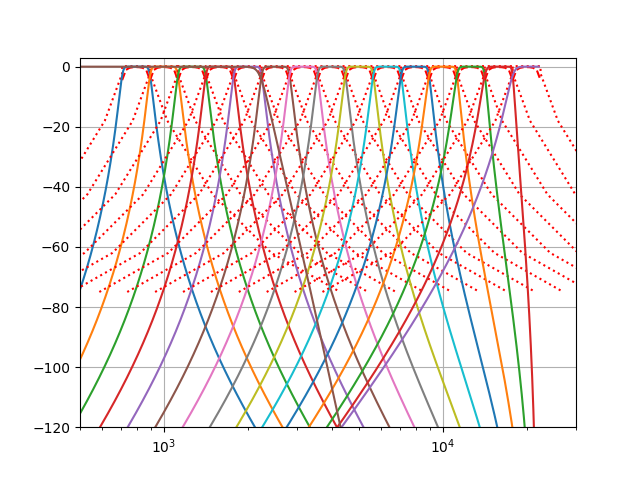

In [153]:
fig, ax = plt.subplots()
ax.set_xlim([500, 30000])
ax.set_ylim([-120, 3])
ax.grid()
x = [None] * 19
for i in filters_band_numbers:
    w, h = signal.sosfreqz(filters[i], worN=15000)
    db = 20*np.log10(np.abs(h))
    for j in range(0, 19):
        x[j] = (x_normalized[j] * frequencies[i]["center"])
    ax.semilogx(x, y_min_spec, 'r--', x, y_max_spec, 'r:', w/np.pi*NQST, db)
w, h = signal.sosfreqz(aliasing_sos, worN=15000)
db = 20*np.log10(np.abs(h))
ax.semilogx(w/np.pi*NQST, db)

### Export to file

In [155]:
output = "// FILTER COEFFICIENTS DESIGNED IN PYTHON\n\n"
output+= "RATE_%d: {\n" % R
output+= "\t%s: {\n" % ("G10" if G==G10 else "G2")
for i in filters_band_numbers[::-1]:
    output += "\t\tFREQ_%d: {\n" % (i+31)
    output += "\t\t\torder: %d;\n" % ORDER
    output += "\t\t\tfilters: (\n"
    for sos in filters[i]:
        output += "\t\t\t\t{b0: %s, b1: %s, b2: %s, a1: %s, a2: %s}\n" % (sos[0],sos[1],sos[2],sos[4],sos[5])
    output += "\t\t\t);\n"
    output += "\t\t};\n"

output += "\t\tANTI_ALIASING: {\n"
output += "\t\t\torder: %d;\n" % len(aliasing_sos)
output += "\t\t\tfilters: (\n"
for sos in aliasing_sos:
    output += "\t\t\t\t{b0: %s, b1: %s, b2: %s, a1: %s, a2: %s}\n" % (sos[0],sos[1],sos[2],sos[4],sos[5])
output += "\t\t\t);\n"
output += "\t\t};\n"
output += "\t};\n"
output += "};\n"

print(output)
with open("filter_%d_%s_%d.conf" % (R, ("G10" if G==G10 else "G2"), ORDER), "w") as f:
    f.write(output)


// FILTER COEFFICIENTS DESIGNED IN PYTHON

RATE_44100: {
	G10: {
		FREQ_44: {
			order: 6;
			filters: (
				{b0: 0.0002875541320690289, b1: -0.0005751082641380578, b2: 0.0002875541320690289, a1: 1.057987481554774, a2: 0.28891213264014654}
				{b0: 1.0, b1: -2.0, b2: 1.0, a1: 1.1693753157321278, a2: 0.424636908252107}
				{b0: 1.0, b1: -2.0, b2: 1.0, a1: 1.4302002438451134, a2: 0.7424270414907089}
				{b0: 1.0, b1: 2.0, b2: 1.0, a1: 1.9999393046811758, a2: 0.9999393056682907}
				{b0: 1.0, b1: 2.0, b2: 1.0, a1: 1.9999555711709724, a2: 0.9999555721580098}
				{b0: 1.0, b1: 2.0, b2: 1.0, a1: 1.9999837384753694, a2: 0.9999837394623351}
			);
		};
		FREQ_43: {
			order: 6;
			filters: (
				{b0: 0.000129310300478359, b1: -0.000258620600956718, b2: 0.000129310300478359, a1: 0.9588364175209777, a2: 0.5711150699980896}
				{b0: 1.0, b1: -2.0, b2: 1.0, a1: 1.1612449488543566, a2: 0.6138186728191106}
				{b0: 1.0, b1: -2.0, b2: 1.0, a1: 0.825041214547064, a2: 0.6496601063005467}
				{b0: 1.0, b